In [143]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

In [144]:
import tensorflow as tf_new
tf = tf_new.compat.v1
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

In [145]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="D:/Datasets/flower_photos.tgz",
                                   extract=True,
                                   cache_subdir="D:/Datasets/")
base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

In [146]:
classes = ['roses', 'daisy', 'dandelion',
           'sunflowers', 'tulips']

In [147]:
total_train = 0
total_val = 0
for cl in classes:
    img_path = os.path.join(base_dir, cl)
    images = glob.glob(img_path + "/*.jpg")
    print("{}: {} изображений".format(cl, len(images)))
    train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

    total_train += len(train)
    total_val += len(val)

    directory = os.path.join(base_dir, "!_train", cl)
    if not os.path.exists(directory):
            os.makedirs(directory)
    for t in train:
        shutil.copy(t, directory)

    directory = os.path.join(base_dir, '!_val', cl)
    if not os.path.exists(directory):
            os.makedirs(directory)
    for v in val:
        shutil.copy(v, directory)

roses: 641 изображений
daisy: 633 изображений
dandelion: 898 изображений
sunflowers: 699 изображений
tulips: 799 изображений


In [148]:
train_dir = os.path.join(base_dir, "!_train")
val_dir = os.path.join(base_dir, "!_val")

In [149]:
batch_size = 100
IMG_SHAPE = 150

In [150]:
image_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=45,
                               zoom_range=(1, 1.5),
                               horizontal_flip=True,
                               width_shift_range=0.15,
                               height_shift_range=0.15)
train_data_gen = image_gen.flow_from_directory(directory=train_dir,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE)
                                               )
val_data_gen = image_gen.flow_from_directory(directory=val_dir,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                            #class_mode='sparse'
                                            )

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


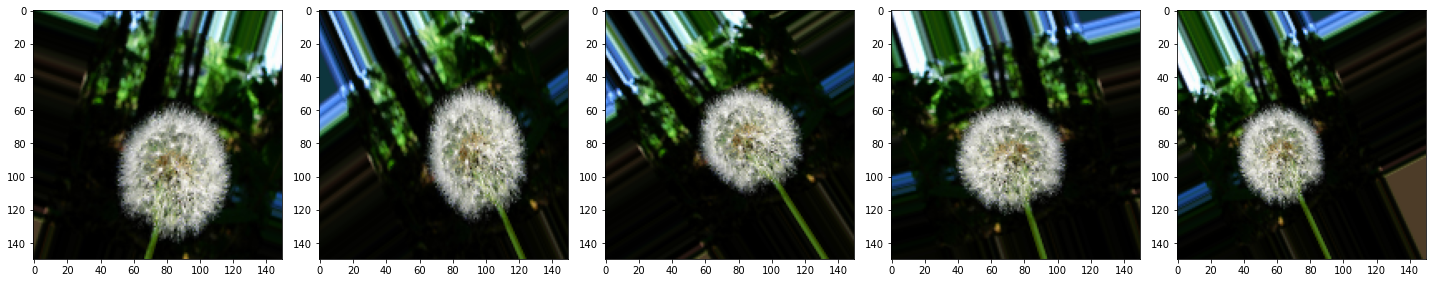

In [151]:
def plotImages(images_arr):
    fix, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    for img, ax in zip(images_arr, axes.flatten()):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [152]:
model = Sequential(layers=[
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),


    Dropout(0.2),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='softmax')
])

In [153]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [154]:
epochs = 7
fitted = model.fit_generator(generator=train_data_gen,
                             steps_per_epoch=int(np.ceil(total_train)/float(batch_size)),
                             epochs=epochs,
                             validation_data=val_data_gen,
                             validation_steps=int(np.ceil(total_val/float(batch_size)))
                             )

Epoch 1/7
29/29 [==============================] - 59s 2s/step - loss: 1.6847 - accuracy: 0.2483 - val_loss: 1.4283 - val_accuracy: 0.3633

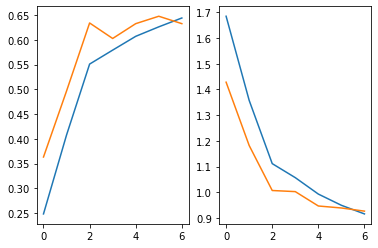

In [155]:
acc = fitted.history['accuracy']
val_acc = fitted.history['val_accuracy']

loss = fitted.history['loss']
val_loss = fitted.history['val_loss']

epochs_range = range(epochs)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='train_acc')
plt.plot(epochs_range, val_acc, label='val_acc')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss)
plt.plot(epochs_range, val_loss)

plt.savefig('./foo3.png')
plt.show()

Found 3 images belonging to 1 classes.
['sunflowers', 'dandelion', 'roses']


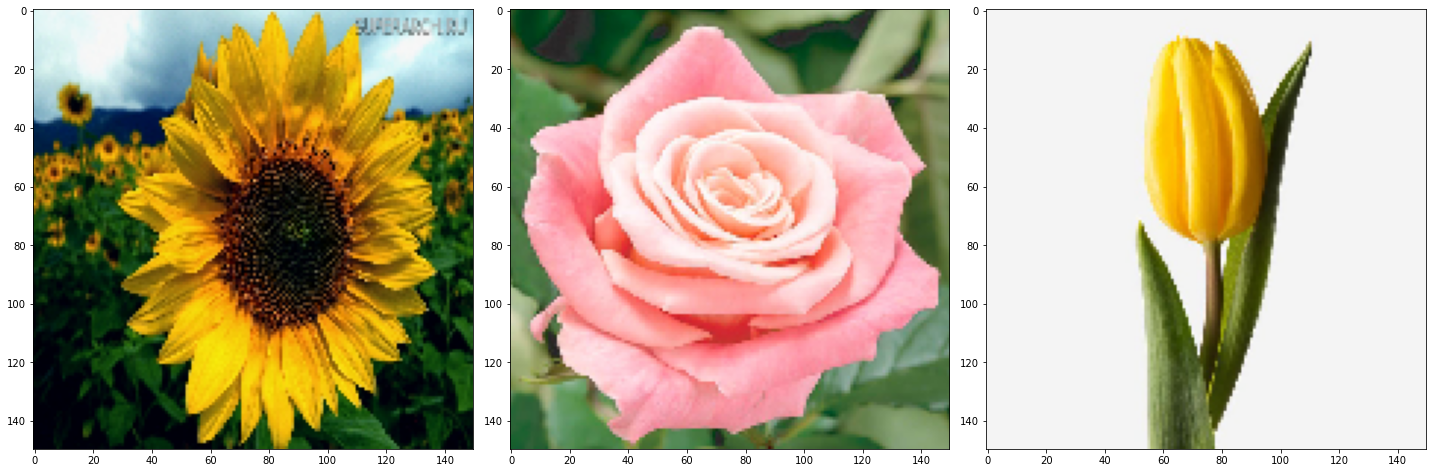

In [156]:
image_gen = ImageDataGenerator(rescale=1./255)
new_data_gen = image_gen.flow_from_directory(directory="./my flowers/",
                                            shuffle=False,
                                            target_size=(IMG_SHAPE,IMG_SHAPE))
answr = model.predict_generator(new_data_gen)
print([classes[i] for i in np.argmax(answr, axis=1)])
new_images = new_data_gen[0][0][:]
plotImages(new_images)